### Setup for data loading

In [1]:
import cv2
import h5py
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt

import numpy as np
import random

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cpu


In [30]:
def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = X.shape[0]
        for i in range(N):
            xi = X[i].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yi = y[i].unsqueeze(0).to(device=device, dtype=torch.long)
            scores = model(xi)
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    train_acc = []
    val_acc = []
    for e in range(epochs):
        for i in range(int(N/epochs)):
            Xt = X[t].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yt = y[t].unsqueeze(0).to(device=device, dtype=torch.long)
            
            scores = model(Xt)
            loss = F.cross_entropy(scores, yt)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            t += 1
            if t % 1000 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train_acc.append(100.*check_accuracy(X_train, y_train, model))
                val_acc.append(100.*check_accuracy(X_val,y_val, model))
                print()
    check_accuracy(X_train, y_train, model)
    check_accuracy(X_val, y_val, model)
                
#     plt.plot(list(range(1,int(t/1000)+1)), train_acc, label='train')
#     plt.plot(list(range(1,int(t/1000)+1)), val_acc, label='val')
#     plt.title('Classification accuracy history')
#     plt.xlabel('Iteration')
#     plt.ylabel('Clasification accuracy')
#     plt.legend()
#     plt.show()

### Loading human detection training data

In [4]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = imgname[8:12]
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)

In [5]:
# Check number of human dectection samples.
nData = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
nData

1607

### Video data loading

In [6]:
# Save corresponding clips 
frame_buffer_n = 5   # how many frames for 3d conv (- n)
frame_every = 3
path = 'videos/'
frames = {}
for iClip in tqdm(bbox):
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames[iClip] = {}
    for iFrame in bbox[iClip]:
        frame_buffer = []
        for iBuffer in range(-(frame_buffer_n-1)*frame_every, 1, frame_every):
            cap.set(1, int(iFrame)+iBuffer)
            ret, frame = cap.read()
            if ret:
                frame_buffer.append(frame)
        frames[iClip][iFrame] = torch.from_numpy(np.stack(frame_buffer))

100%|██████████| 10/10 [05:17<00:00, 31.79s/it]


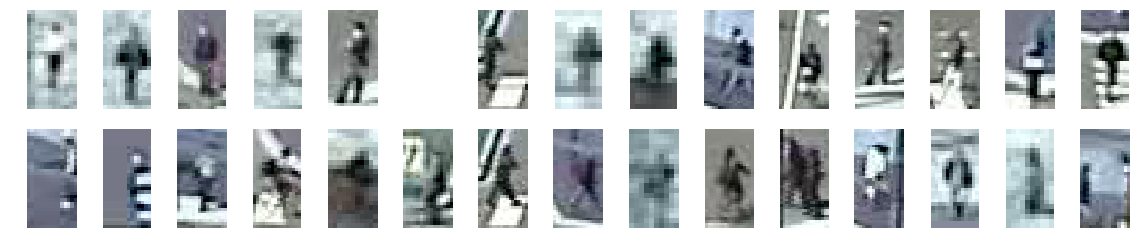

In [25]:
# Random sanity check
# Nearby clips also have high probability of having a person in the crop.
fig = plt.figure(figsize=(20,4))
for i in range(30):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    try:
        k = random.randint(0,4)
        x,y,w,h = bbox[iClip][iFrame][0]
        ax.imshow(frames[iClip][iFrame][k][y:y+h, x:x+w, :])
    except:
        continue

### Training data with still images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 1) crop/zero-padding the image to equal size, or 2) scale the image.

In [26]:
# Generating train data. All images are cropped to (18,36).
# True data
X_sample = torch.zeros(nData,3,36,18)
y_sample = torch.zeros(nData, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-18)/2)
                y -= int((h-36)/2)
                for k in range(5):
                    data = frames[iClip][iFrame][k][y:y+36, x:x+18, :].to(dtype=torch.float32)
                    X_sample[i,:,:,:] = torch.unsqueeze(data.permute(2,0,1),0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

In [27]:
# False data are randomly sampled from images.
n = X_sample.shape[0]
for i in range(n):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    try:
        k = random.randint(0,4)
        data = frames[iClip][iFrame][k][y:y+36, x:x+18,:].to(dtype=torch.float32)
        X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(2,0,1),0)),0)
        y_sample = torch.cat((y_sample, torch.zeros(1)))
    except:
        continue

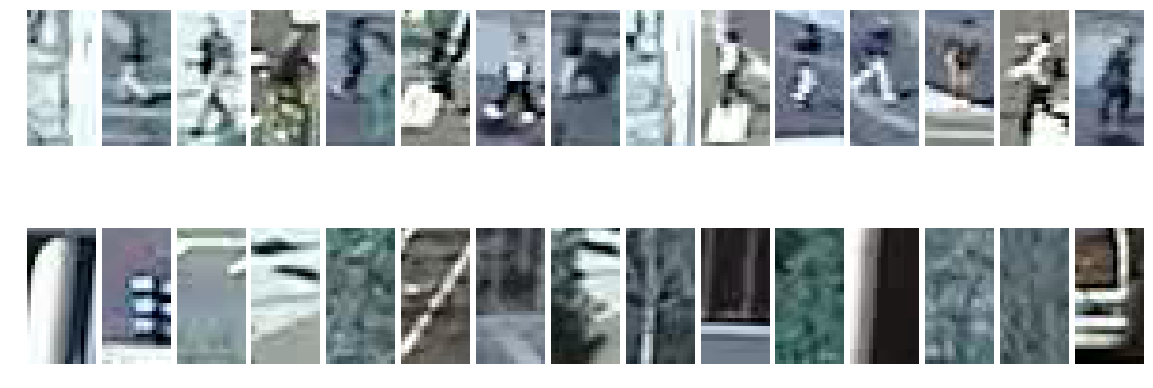

In [28]:
fig = plt.figure(figsize=(20,8))
for i in range(15):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    n = int(random.random()*1300)
    ax.imshow(X_sample[n].permute(1,2,0).to(dtype=torch.uint8))

for i in range(15):
    ax = fig.add_subplot(2,15,i+16)
    ax.axis('off')
    n = int(random.random()*800)+1600
    ax.imshow(X_sample[n].permute(1,2,0).to(dtype=torch.uint8))

fig.subplots_adjust(wspace=0.1, hspace=0)

In [29]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

In [31]:
# Train CNN
model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    Flatten(),
    nn.Linear(16*9*18, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)
optimizer = optim.Adam(model.parameters(), lr=5.e-5, betas=(0.9, 0.999))
train_model(X_train, y_train, model, optimizer, epochs=10)

Iteration 1000, loss = 1.5725
Got 1883 / 2492 correct (75.56)
Got 452 / 624 correct (72.44)

Iteration 2000, loss = 0.0233
Got 2250 / 2492 correct (90.29)
Got 549 / 624 correct (87.98)

Got 2295 / 2492 correct (92.09)
Got 562 / 624 correct (90.06)


In [21]:
inputs = torch.from_numpy(np.vstack((frames['001']['0201'][4].permute(2, 0, 1).unsqueeze(0), frames['001']['0401'][4].permute(2, 0, 1).unsqueeze(0)))).to(dtype=torch.float32)
filters = torch.from_numpy(list(model.parameters())[0].cpu().detach().numpy()).to(dtype=torch.float32)
z = F.conv2d(inputs, filters, padding=1, stride=1)

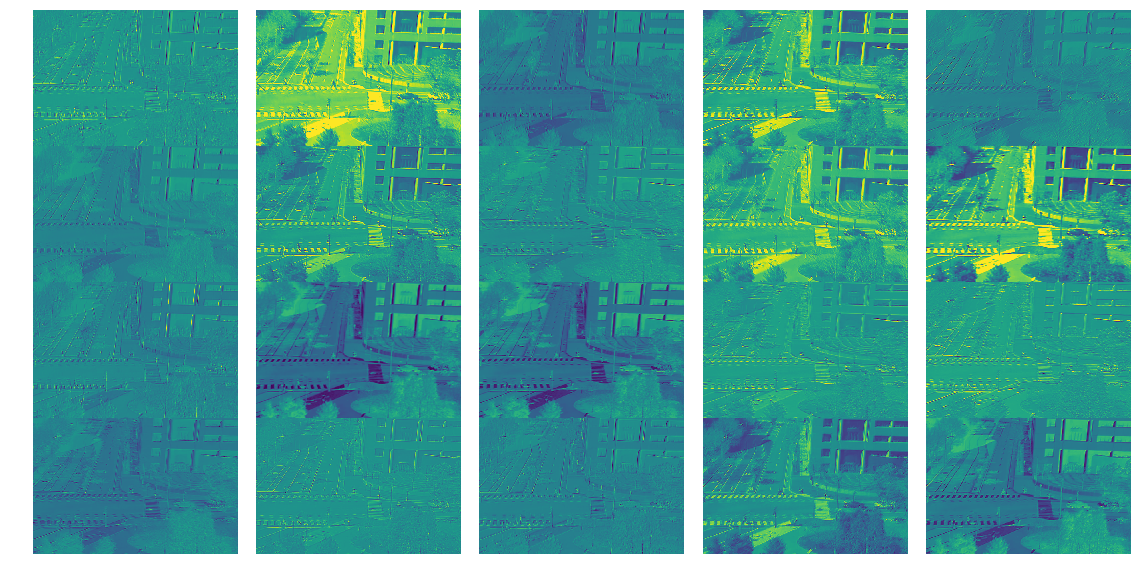

In [24]:
fig = plt.figure(figsize=(20,10))
for i in range(20):
    ax = fig.add_subplot(4,5,i+1)
    ax.axis('off')
    ax.imshow(z[0, i, :, :].numpy(), vmax=120)
fig.subplots_adjust(wspace=0, hspace=0)

### Training data with (3d; stack of) images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 1) crop/zero-padding the image to equal size, or 2) scale the image.

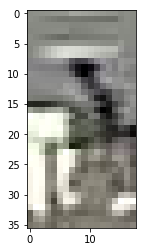

In [107]:
# Generating train data. All images are cropped to (36, 18).# Genera 
# True data
X_sample = torch.zeros(nData,3,frame_buffer_n,36,18)
y_sample = torch.zeros(nData, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-18)/2)
                y -= int((h-36)/2)
                if i == 100:
                    imshow(frames[iClip][iFrame][-1, y:y+36, x:x+18,:])
                data = frames[iClip][iFrame][:, y:y+36, x:x+18, :].to(dtype=torch.float32)
                X_sample[i,:,:,:,:] = torch.unsqueeze(data.permute(3,0,1,2), 0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

100%|██████████| 1571/1571 [00:32<00:00, 47.81it/s]


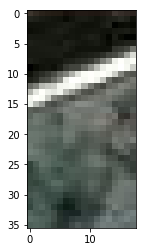

In [108]:
# False data are randomly sampled from images.# False  
n = X_sample.shape[0]
for i in tqdm(range(1 * n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    try:
        if i == 100:
            imshow(frames[iClip][iFrame][-1, y:y+36, x:x+18,:])
        data = frames[iClip][iFrame][:, y:y+36, x:x+18,:].to(dtype=torch.float32)
        X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(3,0,1,2),0)),0)
        y_sample = torch.cat((y_sample, torch.zeros(1)))
    except:
        continue

In [109]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

Iteration 100, loss = 0.6134
Got 1271 / 2496 correct (50.92)
Got 301 / 624 correct (48.24)

Iteration 200, loss = 0.4158
Got 1531 / 2496 correct (61.34)
Got 396 / 624 correct (63.46)

Iteration 300, loss = 0.3190
Got 1870 / 2496 correct (74.92)
Got 440 / 624 correct (70.51)

Iteration 400, loss = 1.2423
Got 1570 / 2496 correct (62.90)
Got 408 / 624 correct (65.38)

Iteration 500, loss = 1.0435
Got 2067 / 2496 correct (82.81)
Got 510 / 624 correct (81.73)

Iteration 600, loss = 0.3516
Got 2115 / 2496 correct (84.74)
Got 527 / 624 correct (84.46)

Iteration 700, loss = 0.4045
Got 2119 / 2496 correct (84.90)
Got 531 / 624 correct (85.10)

Iteration 800, loss = 0.1057
Got 2076 / 2496 correct (83.17)
Got 501 / 624 correct (80.29)

Iteration 900, loss = 0.0250
Got 1574 / 2496 correct (63.06)
Got 402 / 624 correct (64.42)

Iteration 1000, loss = 0.0840
Got 2241 / 2496 correct (89.78)
Got 551 / 624 correct (88.30)

Iteration 1100, loss = 0.1430
Got 2239 / 2496 correct (89.70)
Got 557 / 624 cor

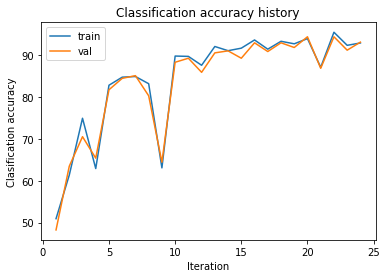

In [110]:
# Train CNN
model = nn.Sequential(
    nn.Conv3d(3, 32, 5, padding=2),
    nn.BatchNorm3d(32),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv3d(32, 32, 3, padding=1),
    nn.BatchNorm3d(32),
    nn.MaxPool3d(2, stride=2),
    nn.ReLU(),
    nn.Conv3d(32, 16, 3, padding=1),
    nn.BatchNorm3d(16),
    nn.ReLU(),
    Flatten(),
    nn.Linear(2*16*9*18, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)
optimizer = optim.Adam(model.parameters(), lr=5.e-5, betas=(0.9, 0.999))
train_model(X_train, y_train, model, optimizer, epochs=10)

In [111]:
inputs = torch.from_numpy(np.vstack((frames['001']['0201'].permute(3, 0, 1, 2).unsqueeze(0), frames['001']['0401'].permute(3, 0, 1, 2).unsqueeze(0)))).to(dtype=torch.float32)
filters = torch.from_numpy(list(model.parameters())[0].cpu().detach().numpy()).to(dtype=torch.float32)
z = F.conv3d(inputs, filters, padding=1, stride=1)

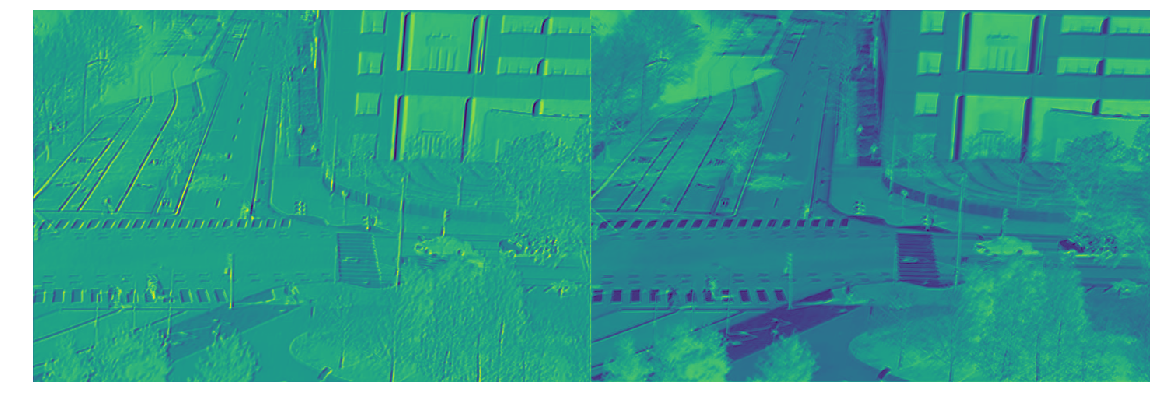

In [115]:
fig = plt.figure(figsize=(20,10))
for i,x in enumerate([0,9]):
    ax = fig.add_subplot(1,2,i+1)
    ax.axis('off')
    ax.imshow(z[0, x, 0, :, :].numpy(), vmax=100)
fig.subplots_adjust(wspace=0, hspace=0)